In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
%matplotlib inline

#input, times weight, add a bias, activate 

In [2]:
# CONSTANTS

In [3]:
num_inputs = 2

In [4]:
num_neurons = 3 

In [5]:
# PLACEHOLDERS 

In [6]:
x0 = tf.placeholder(tf.float32, [None, num_inputs])

In [7]:
x1 = tf.placeholder(tf.float32, [None, num_inputs])

In [8]:
# VARIABLES 

In [9]:
Wx = tf.Variable(tf.random_normal(shape=[num_inputs, num_neurons]))

In [10]:
Wy = tf.Variable(tf.random_normal(shape=[num_neurons, num_neurons]))

In [11]:
b = tf.Variable(tf.zeros([1,num_neurons]))

In [12]:
# GRAPHS 

In [13]:
y0 = tf.tanh(tf.matmul(x0,Wx) + b)

In [14]:
y1 = tf.tanh(tf.matmul(y0,Wy) + tf.matmul(x1,Wx) + b)

In [15]:
init = tf.global_variables_initializer()

In [16]:
# CREATE DATA

In [17]:
#t=0
x0_batch = np.array([[0,1], [2,3], [4,5]])

#t=1
x1_batch = np.array([[100,101], [102,103], [104,105]])


In [18]:
with tf.Session() as sess:
    
    sess.run(init)
    
    y0_output_vals , y1_output_vals = sess.run([y0,y1], feed_dict={x0:x0_batch, x1:x1_batch})

In [19]:
y0_output_vals

array([[ 0.04888376,  0.97957522,  0.62380499],
       [ 0.99302727,  0.99999994,  0.97709852],
       [ 0.999973  ,  1.        ,  0.9988423 ]], dtype=float32)

In [20]:
y1_output_vals

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]], dtype=float32)

In [21]:
Wx

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32_ref>

# Vanishing Gradients: LSTM and GRU 

In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        
        # Grab random starting point for each batch 
        rand_start = np.random.rand(batch_size,1)
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        # Create batch time series on the x axis 
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create the Y data for the time series x axis from previous step 
        y_batch = np.sin(batch_ts)
        
        # FORMATTING for  RNN 
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1) , batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1)
        

In [24]:
ts_data = TimeSeriesData(250,0,10)

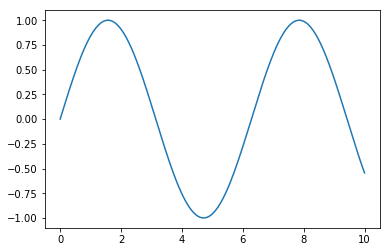

In [25]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [26]:
num_time_steps = 30

In [27]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

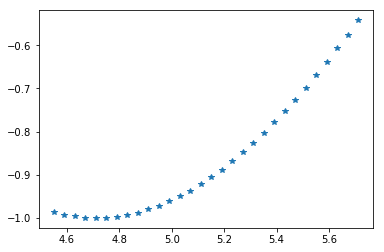

In [28]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

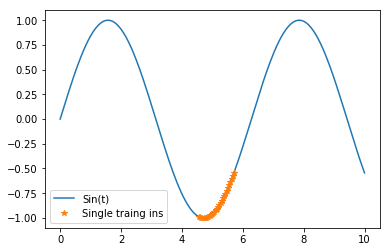

In [29]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*', label='Single traing ins')

plt.legend()

# Training data

In [30]:
train_inst = np.linspace(5, 5 + ts_data.resolution*(num_time_steps+1),num_time_steps+1)

In [31]:
train_inst

array([ 5.        ,  5.04133333,  5.08266667,  5.124     ,  5.16533333,
        5.20666667,  5.248     ,  5.28933333,  5.33066667,  5.372     ,
        5.41333333,  5.45466667,  5.496     ,  5.53733333,  5.57866667,
        5.62      ,  5.66133333,  5.70266667,  5.744     ,  5.78533333,
        5.82666667,  5.868     ,  5.90933333,  5.95066667,  5.992     ,
        6.03333333,  6.07466667,  6.116     ,  6.15733333,  6.19866667,
        6.24      ])

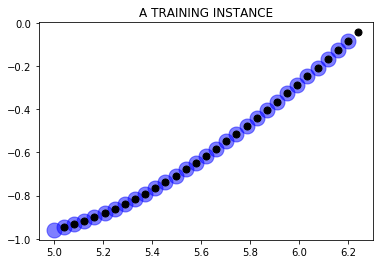

In [32]:
plt.title('A TRAINING INSTANCE')

plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='instance')

plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]),'ko',markersize=7,label='Target')

# Creating the model

In [33]:
tf.reset_default_graph()

In [34]:
num_inputs = 1 

In [35]:
num_neurons = 100 

In [36]:
num_outputs = 1

In [37]:
learning_rate = 0.0001

In [38]:
num_train_iterations = 2000

In [39]:
batch_size = 1

In [40]:
# PLACEHOLDERS

In [41]:
X = tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])

In [42]:
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

In [43]:
# RNN CELL LAYER

In [44]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons,activation=tf.nn.relu),
    output_size=num_outputs
)

In [45]:
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [46]:
loss = tf.reduce_mean(tf.square(outputs-y))

In [47]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [48]:
train = optimizer.minimize(loss)

In [49]:
init = tf.global_variables_initializer()

In [50]:
# SESSION 

In [51]:
saver = tf.train.Saver()

In [52]:
with tf.Session() as sess:
    
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size,num_time_steps)
        
        sess.run(train,feed_dict = {X:X_batch, y:y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration,"\tMSE",mse)
            
        saver.save(sess,"./rnn_time_series_model_code_wout_20170601")

0 	MSE 0.807377
100 	MSE 0.0401437
200 	MSE 0.0197801
300 	MSE 0.0273673
400 	MSE 0.00270476
500 	MSE 0.0154981
600 	MSE 0.011403
700 	MSE 0.0181273
800 	MSE 0.0111486
900 	MSE 0.0108289
1000 	MSE 0.00490174
1100 	MSE 0.0124217
1200 	MSE 0.0033368
1300 	MSE 0.0146904
1400 	MSE 0.00576366
1500 	MSE 0.00226076
1600 	MSE 0.00625924
1700 	MSE 5.2336e-05
1800 	MSE 0.00759145
1900 	MSE 0.00391144


In [53]:
with tf.Session() as sess:
    
    saver.restore(sess,"./rnn_time_series_model_code_wout_20170601")
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_code_wout_20170601


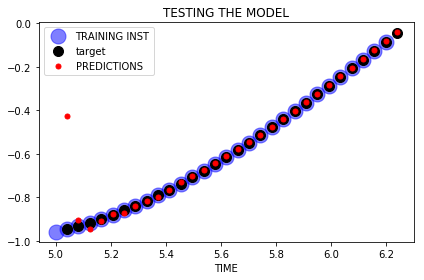

In [54]:
plt.title("TESTING THE MODEL")

#TRAINING INSTANCE
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15, alpha=0.5, label='TRAINING INST')

plt.plot(train_inst[1:], np.sin(train_inst[1:]), 'ko', markersize=10, label='target')

plt.plot(train_inst[1:], y_pred[0,:,0], 'r.', markersize=10, label = 'PREDICTIONS')

plt.xlabel('TIME')

plt.legend()

plt.tight_layout()

# Generating a new sequence 

In [57]:
with tf.Session() as sess:
    
    saver.restore(sess,"./rnn_time_series_model_code_wout_20170601")
    
    # SEED
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs,feed_dict={X:X_batch})
        
        zero_seq_seed.append(y_pred[0,-1,0])
        

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_code_wout_20170601


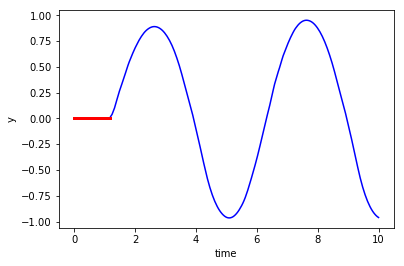

In [58]:
plt.plot(ts_data.x_data,zero_seq_seed,'b-')
plt.plot(ts_data.x_data[:num_time_steps],zero_seq_seed[:num_time_steps],'r',linewidth=3)
plt.xlabel('time')
plt.ylabel('Y')

Here we generate the sequence based on only the zeros, but we still use the model that is trained on the sinus. In the next example we see the difference for when we use the instance of a the actual sinus. 

In [59]:
with tf.Session() as sess:
    
    saver.restore(sess,"./rnn_time_series_model_code_wout_20170601")
    
    # SEED
    training_instance = list(ts_data.y_true[:30])
    
    for iteration in range(len(training_instance)-num_time_steps):
        
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs,feed_dict={X:X_batch})
        
        training_instance.append(y_pred[0,-1,0])
        

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_code_wout_20170601


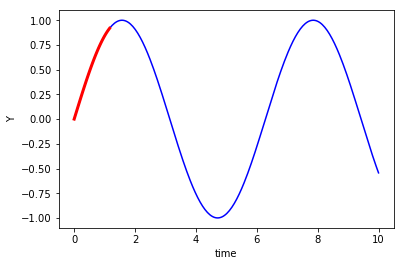

In [61]:
plt.plot(ts_data.x_data,ts_data.y_true,'b-')
plt.plot(ts_data.x_data[:num_time_steps],training_instance[:num_time_steps],'r',linewidth=3)
plt.xlabel('time')
plt.ylabel('Y')